<br>
First of all, of course, an MLP model was a good option for this problem.<br>
But, I tried to create a CNN model for a binary classification problem using TPU. <br>

- The data has 28 features. I converted the input shape from <b>(None, 28)</b> to <b>(None, 28 ,1)</b> for the convolution operation.
- I split the first 4 tfrecord files of the training dataset for testing. (nearly 1250000 samples)


## Results
<br>

|                 	| Score    	|
|-----------------	|----------	|
| Test AUC Score  	| 0.83351  	|
| Test Precision  	| 0.76832  	|
| Test Recall     	| 0.75736  	|
| Test Accuracy   	| 74.996 % 	|


In [2]:
# Importing dependencies

import warnings 
warnings.filterwarnings('ignore')

import os
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import shutil

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.io import FixedLenFeature


In [3]:
# Connecting tpu and creating strategy

tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()
strategy = tf.distribute.TPUStrategy(tpu)

INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.
INFO:tensorflow:Initializing the TPU system: local
INFO:tensorflow:Finished initializing TPU system.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:0, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:1, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:2, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:3, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:4, TPU

In [4]:
# constants

AUTO = tf.data.experimental.AUTOTUNE
BATCH_SIZE_PER_REPLICA = 2 ** 11 
UNITS = 2 ** 11 
steps_per_execution = 256
ACTIVATION = 'relu'
DROPOUT = 0.1

dataset_size = int(11e6)
val_size = int(5e5)

train_size = dataset_size - val_size

batch_size = BATCH_SIZE_PER_REPLICA * strategy.num_replicas_in_sync
steps_per_epoch = train_size  // batch_size
validation_steps = val_size // batch_size


# <span style="color:#e74c3c;"> Creating </span> Datasets


In [5]:
# Feature decoding and creating a loading function

def make_decoder(feature_description):
    def decoder(example):
        example = tf.io.parse_single_example(example, feature_description)
        features = tf.io.parse_tensor(example['features'], tf.float32)
        features = tf.reshape(features, [28, 1])
        label = example['label']
        return features, label
    return decoder


def load_dataset(filenames, decoder, ordered=False):
    AUTO = tf.data.experimental.AUTOTUNE
    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False
    dataset = (
        tf.data
        .TFRecordDataset(filenames, num_parallel_reads=AUTO)
        .with_options(ignore_order)
        .map(decoder, AUTO))
    return dataset

In [6]:
# Creating 2 directories for training and testing

os.mkdir(os.path.join('/kaggle/working/','new_training' ))
os.mkdir(os.path.join('/kaggle/working/', 'testing' ))

In [7]:
# Splitting the train data
# The first 4 data for testing, the others for training

main_path_training = '/kaggle/input/higgs-boson/training'

count = 0 
for i in  os.listdir(main_path_training):
    count += 1
    if count < 5:
        shutil.copyfile(os.path.join(main_path_training, i), os.path.join('/kaggle/working/testing',i) )
    else:
        shutil.copyfile(os.path.join(main_path_training, i),os.path.join('/kaggle/working/new_training',i) )

In [8]:
# Creating tf.Datasets

feature_description = { 'features' : FixedLenFeature([], tf.string), 'label': FixedLenFeature([], tf.float32) }

decoder = make_decoder(feature_description)

main_path_old = '/kaggle/input/higgs-boson'
main_path_new = '/kaggle/working/'

train_files = tf.io.gfile.glob( main_path_new + "/new_training" + "/*.tfrecord" )
validation_files = tf.io.gfile.glob( main_path_old + "/validation" + "/*.tfrecord" )
test_files = tf.io.gfile.glob( main_path_new + "/testing" + "/*.tfrecord" )


ds_train = load_dataset(train_files,decoder,  ordered=False)
ds_train =(ds_train
          .cache()
          .repeat() 
          .shuffle(2 ** 19)
          .batch(batch_size)
          .prefetch(AUTO))



ds_valid = load_dataset(validation_files, decoder, ordered=False)
ds_valid = (
    ds_valid
    .batch(batch_size)
    .cache()
    .prefetch(AUTO)
)


ds_test = load_dataset(test_files, decoder, ordered=False)
ds_test = (
    ds_test
    .batch(batch_size)
    .cache()
    .prefetch(AUTO)
)

# <span style="color:#e74c3c;"> CNN </span> Model

In [9]:
# Creating model

with strategy.scope():
    inputs = tf.keras.Input(shape = [28,1])
    
    x = layers.Conv1D(256, 3 , padding = 'same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Dropout(0.1)(x)
    
        
    x = layers.Conv1D(512, 3 , padding = 'same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Dropout(0.1)(x)
    
    
    x = layers.Conv1D(1024, 3 , padding = 'same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Dropout(0.1)(x)
    
    x = layers.Conv1D(2048, 3 , padding = 'same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Dropout(0.1)(x)
    
    
    x = layers.Conv1D(4096, 3 , padding = 'same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Dropout(0.1)(x)
    
    
    x = layers.GlobalAveragePooling1D()(x)

    outputs = tf.keras.layers.Dense(1, activation = 'sigmoid')(x)
    model = keras.Model(inputs = inputs, outputs = outputs)
    
    
    model.compile( optimizer = 'adam',  loss = 'binary_crossentropy',    metrics=['AUC', 'Precision', 'Recall' , 'binary_accuracy'],
    steps_per_execution=steps_per_execution )

In [10]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 1)]           0         
                                                                 
 conv1d (Conv1D)             (None, 28, 256)           1024      
                                                                 
 batch_normalization (BatchN  (None, 28, 256)          1024      
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 28, 256)           0         
                                                                 
 dropout (Dropout)           (None, 28, 256)           0         
                                                                 
 conv1d_1 (Conv1D)           (None, 28, 512)           393728    
                                                             

In [11]:
# training

my_callbacks = [EarlyStopping( patience=2, min_delta=0.001, restore_best_weights=True),
                ReduceLROnPlateau(patience=1, factor=0.3, min_lr=0.001)]


history = model.fit(ds_train, validation_data=ds_valid, epochs=13, steps_per_epoch=steps_per_epoch, validation_steps=validation_steps, callbacks= my_callbacks)

Epoch 1/13
640/640 [==============================] - 322s 502ms/step - loss: 0.6217 - auc: 0.7146 - precision: 0.6558 - recall: 0.7252 - binary_accuracy: 0.6527 - val_loss: 0.5714 - val_auc: 0.7778 - val_precision: 0.6741 - val_recall: 0.8233 - val_binary_accuracy: 0.6952 - lr: 0.0010
Epoch 2/13
640/640 [==============================] - 170s 265ms/step - loss: 0.5476 - auc: 0.7913 - precision: 0.7236 - recall: 0.7447 - binary_accuracy: 0.7141 - val_loss: 0.5484 - val_auc: 0.8054 - val_precision: 0.6844 - val_recall: 0.8549 - val_binary_accuracy: 0.7139 - lr: 0.0010
Epoch 3/13
640/640 [==============================] - 168s 263ms/step - loss: 0.5327 - auc: 0.8050 - precision: 0.7356 - recall: 0.7517 - binary_accuracy: 0.7253 - val_loss: 0.5454 - val_auc: 0.8138 - val_precision: 0.8047 - val_recall: 0.6152 - val_binary_accuracy: 0.7167 - lr: 0.0010
Epoch 4/13
640/640 [==============================] - 170s 265ms/step - loss: 0.5241 - auc: 0.8125 - precision: 0.7421 - recall: 0.7569 - b

# <span style="color:#e74c3c;"> Train </span> Results

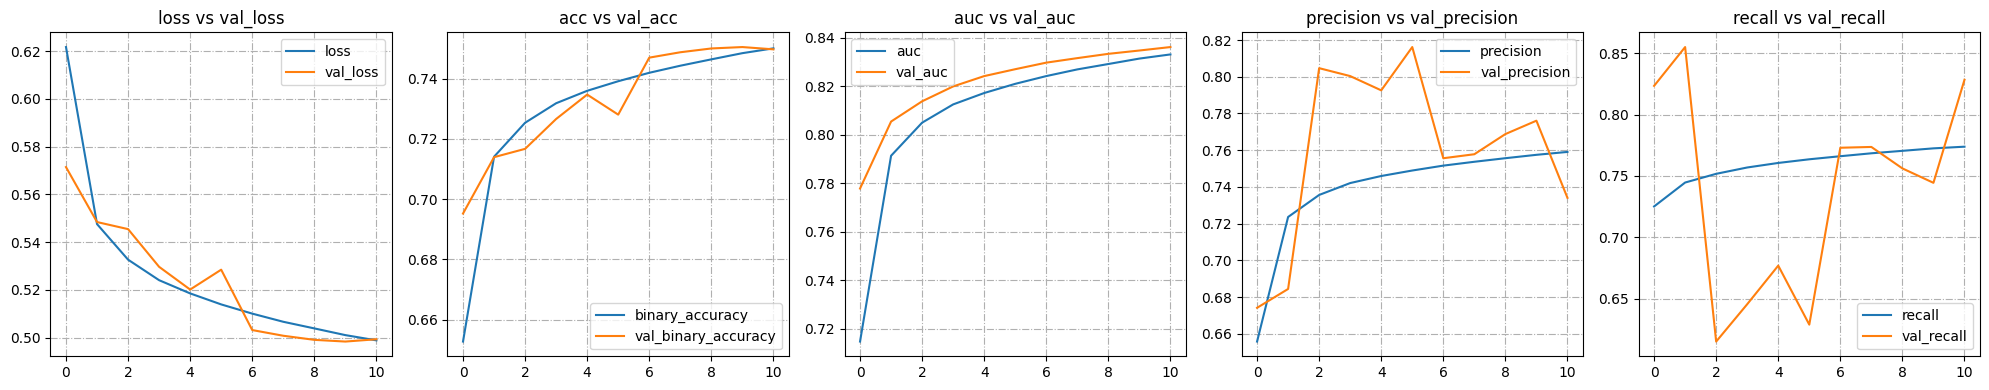

In [12]:
fig, axs = plt.subplots(1, 5,  figsize=(20,4))

axs[0].grid(linestyle="dashdot")
axs[0].set_title('loss vs val_loss')
axs[0].plot(history.history['loss'])
axs[0].plot(history.history['val_loss'])
axs[0].legend(["loss", "val_loss"])

axs[1].grid(linestyle="dashdot")
axs[1].set_title('acc vs val_acc')
axs[1].plot(history.history['binary_accuracy'])
axs[1].plot(history.history['val_binary_accuracy'])
axs[1].legend(["binary_accuracy", "val_binary_accuracy"])

axs[2].grid(linestyle="dashdot")
axs[2].set_title('auc vs val_auc')
axs[2].plot(history.history['auc'])
axs[2].plot(history.history['val_auc'])
axs[2].legend(["auc", "val_auc"])

axs[3].grid(linestyle="dashdot")
axs[3].set_title('precision vs val_precision')
axs[3].plot(history.history['precision'])
axs[3].plot(history.history['val_precision'])
axs[3].legend(["precision", "val_precision"])

axs[4].grid(linestyle="dashdot")
axs[4].set_title('recall vs val_recall')
axs[4].plot(history.history['recall'])
axs[4].plot(history.history['val_recall'])
axs[4].legend(["recall", "val_recall"])



plt.tight_layout()

# <span style="color:#e74c3c;"> Test </span> Results

In [14]:
test_evaluation = model.evaluate(ds_test, steps = 50)

print('Test AUC Score : {0:.5f}'.format(test_evaluation[1]) )
print('Test Precision : {0:.5f}'.format(test_evaluation[2]) )
print('Test Recall : {0:.5f}'.format(test_evaluation[3]) )
print('Test Accuracy : {0:.3f} %'.format(test_evaluation[4]*100) )


50/50 [==============================] - 21s 410ms/step - loss: 0.4986 - auc: 0.8335 - precision: 0.7683 - recall: 0.7574 - binary_accuracy: 0.7500
Test AUC Score : 0.83351
Test Precision : 0.76832
Test Recall : 0.75736
Test Accuracy : 74.996 %
